### Training a Graph Convolution Model
Now that we have the data appropriately formatted, we can use this data to train a Graph Convolution model.  First we need to import the necessary libraries. 

In [1]:
import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools

Now let's define a function to create a GraphConvModel.  In this case we will be creating a classification model.  Since we will be apply the model later on a different dataset, it's a good idea to create a directory in which to store the model. 

In [2]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification', model_dir="./model_dir")
    return model

Now we will read in the dataset that we just created.  

In [3]:
dataset_file = "dude_erk2_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

Now that we have the dataset loaded, let's build a model.
We will create training and test sets to evaluate the model's performance. In this case we will use the RandomSplitter().  DeepChem offers a number of other splitters such as the ScaffoldSplitter, which will divide the dataset by chemical scaffold or the ButinaSplitter which will first cluster the data then split the dataset so that different clusters will end up in the training and test sets. 

In [4]:
splitter = dc.splits.RandomSplitter()

With the dataset split, we can train a model on the training set and test that model on the validation set. 
At this point we can define some metrics and evaluate the performance of our model. In this case our dataset is unbalanced, we have a small number of active compounds and a large number of inactive compounds. Given this difference, we need to use a metric that reflects the performance on unbalanced datasets. One metric that is apporpriate for datasets like this is the Matthews correlation coefficient (MCC). Put more info about MCC here.

In [5]:
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In order to evaluate the performance of our moldel, we will perform 10 folds of cross valiation, where we train a model on the training set and validate on the validation set. 

In [6]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10
for i in range(0,cv_folds):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

To visualize the preformance of our models on the training and test data, we can make boxplots of the models' performance.

/home/peastman/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

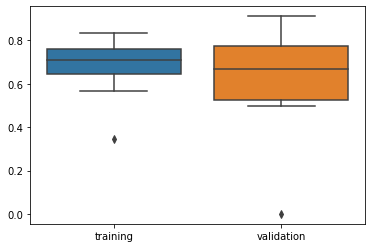

In [7]:
sns.boxplot(["training"]*cv_folds+["validation"]*cv_folds,training_score_list+validation_score_list)

It is also useful to visualize the result of our model.  In order to do this, we will generate a set of predictions for a validation set. 

In [8]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [9]:
pred

[array([0.99042904, 0.00957101], dtype=float32),
 array([0.98227006, 0.01772992], dtype=float32),
 array([0.92205983, 0.07794016], dtype=float32),
 array([0.98902786, 0.01097208], dtype=float32),
 array([0.99804235, 0.00195763], dtype=float32),
 array([0.9958469 , 0.00415305], dtype=float32),
 array([0.9920204 , 0.00797955], dtype=float32),
 array([0.99746466, 0.00253534], dtype=float32),
 array([0.99874324, 0.00125677], dtype=float32),
 array([0.95313686, 0.04686316], dtype=float32),
 array([0.9847772 , 0.01522283], dtype=float32),
 array([0.98530376, 0.01469625], dtype=float32),
 array([0.9926399 , 0.00736017], dtype=float32),
 array([0.9944606 , 0.00553944], dtype=float32),
 array([0.99667156, 0.00332846], dtype=float32),
 array([0.9987361 , 0.00126395], dtype=float32),
 array([0.9716935 , 0.02830647], dtype=float32),
 array([0.9944877 , 0.00551229], dtype=float32),
 array([0.9889704 , 0.01102956], dtype=float32),
 array([0.9973036 , 0.00269632], dtype=float32),
 array([0.99028474, 

**The results of predict on a GraphConv model are returned as a list of lists.  Is this the intent? It doesn't seem consistent across models.  RandomForest returns a list. For convenience, we will put our predicted results into a Pandas dataframe.**

In [10]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

We can easily add the activity class (1 = active, 0 = inactive) and the SMILES string for our predicted moleculesto the dataframe.  __Is the moleculed id retained as part of the DeepChem dataset? I can't find it__

In [11]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [12]:
pred_df.head()

,neg,pos,active,SMILES
0,0.990429,0.009571,0,C1=CC(=CC2=CC=N[C@@H]21)/C=C(\C#N)/C(=O)N
1,0.982270,0.017730,0,c1ccc(cc1)CCNC(=O)CSC2=NN[C@@H](N2c3ccc(cc3)F)...
2,0.922060,0.077940,0,c1cc(c(cc1Oc2c(c(c(c(c2F)F)F)F)F)[N+](=O)[O-])N
3,0.989028,0.010972,0,NC(=O)[C@@H]1CCCCN1C(=O)N1CC[C@H](C(=O)O)C1
4,0.998042,0.001958,0,CC1=C[C@@H](N=N1)[C@H]2NN[C@@H]3N2N=C(S3)c4ccc...


In [13]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
338,0.418481,0.581519,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NC(CO...
127,0.430035,0.569965,1,C[C@H](c1ccccc1)NC(=O)c2cc(c[nH]2)c3c(cn[nH]3)...
179,0.447756,0.552244,1,CCN(C)C(=O)c1cc(c[nH]1)c2c(cn[nH]2)c3cccc(c3)Cl
273,0.551665,0.448335,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
106,0.583746,0.416254,1,c1ccc(cc1)[C@@H](C(=O)N)NC(=O)c2cc(c[nH]2)c3c(...
272,0.670283,0.329717,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCc4c...
145,0.765286,0.234714,0,c1ccc2c(c1)[nH]c(n2)CC(Cc3[nH]c4ccccc4n3)(c5[n...
49,0.806742,0.193258,1,CNC(=O)Nc1ccc(cn1)CNc2c(cnn2C)C(=O)Nc3ccc(cc3)...
22,0.828664,0.171336,0,c1c(cc(c2c1OCO2)Br)c3nc4c(c(n3)NN)CCC4
173,0.845872,0.154128,1,c1c[nH]c2c1/C(=C\3/C(=O)N=C(N3)N)/CCNC2=O


/home/peastman/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='active', ylabel='pos'>

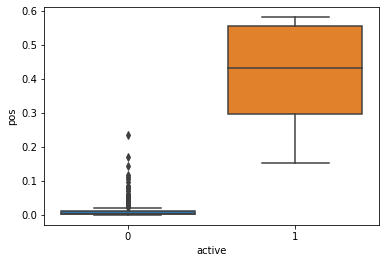

In [14]:
sns.boxplot(pred_df.active,pred_df.pos)

The performance of our model is very good, we can see a clear separation between the active and inactive compounds.  It appears that only one of our active compounds receieved a low positive score. Let's look more closely. 

In [15]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

In [16]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")

,neg,pos,active,SMILES,Mol
49,0.806742,0.193258,1,CNC(=O)Nc1ccc(cn1)CNc2c(cnn2C)C(=O)Nc3ccc(cc3)...,
106,0.583746,0.416254,1,c1ccc(cc1)[C@@H](C(=O)N)NC(=O)c2cc(c[nH]2)c3c(...,
173,0.845872,0.154128,1,c1c[nH]c2c1/C(=C\3/C(=O)N=C(N3)N)/CCNC2=O,
272,0.670283,0.329717,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCc4c...,
273,0.551665,0.448335,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,

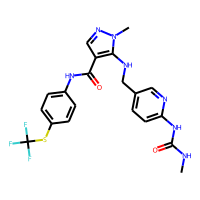
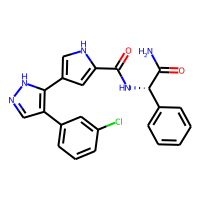
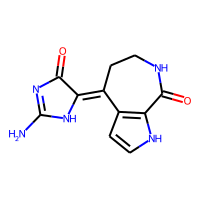
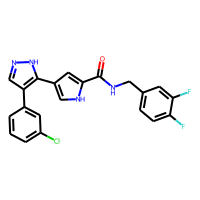
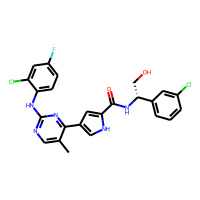

In [17]:
false_negative_df

In [18]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")

In [19]:
false_positive_df

,neg,pos,active,SMILES,Mol


Now that we've evaluated our model's performance we can retrain the model on the entire dataset and save it. 

In [20]:
model.fit(dataset)

0.0013205933074156443